# Importação das bibliotecas e modelos

In [ ]:
!pip install catboost
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.model_selection import train_test_split
import datetime
from datetime import timedelta
from sklearn.utils import resample
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import confusion_matrix,classification_report,recall_score,roc_auc_score,auc, confusion_matrix, roc_curve,accuracy_score
import sklearn 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
import catboost as catboost
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_roc_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Carregando os dados

In [ ]:
hotel_df = pd.read_csv("/content/drive/MyDrive/hotel_bookings.csv")
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
hotel_df.shape

(119390, 32)

# Pré-processamento de dados

Verificando valores ausentes

In [ ]:
# percentual dos valores ausentes
perc_null=((hotel_df.isnull().sum()/hotel_df.shape[0])*100).sort_values(ascending=False)
perc_null

company                           94.306893
agent                             13.686238
country                            0.408744
children                           0.003350
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                       0.000000
hotel                              0.000000
previous_cancellations             0.000000
days_in_waiting_list               0.000000
customer_type                      0.000000
adr                                0.000000
required_car_parking_spaces        0.000000
total_of_special_requests          0.000000
reservation_status                 0.000000
previous_bookings_not_canceled     0.000000
is_repeated_guest                  0.000000
is_canceled                        0.000000
distribution_channel               0.000000
market_segment                     0.000000
meal                               0.000000
babies                          

In [ ]:
#Agent e Company são colunas de ID e possuem muitos valores ausentes.
#Então, vamos remover
hotel_df =  hotel_df.drop(['agent','company'],axis = 1)

# Gráfico de correlação

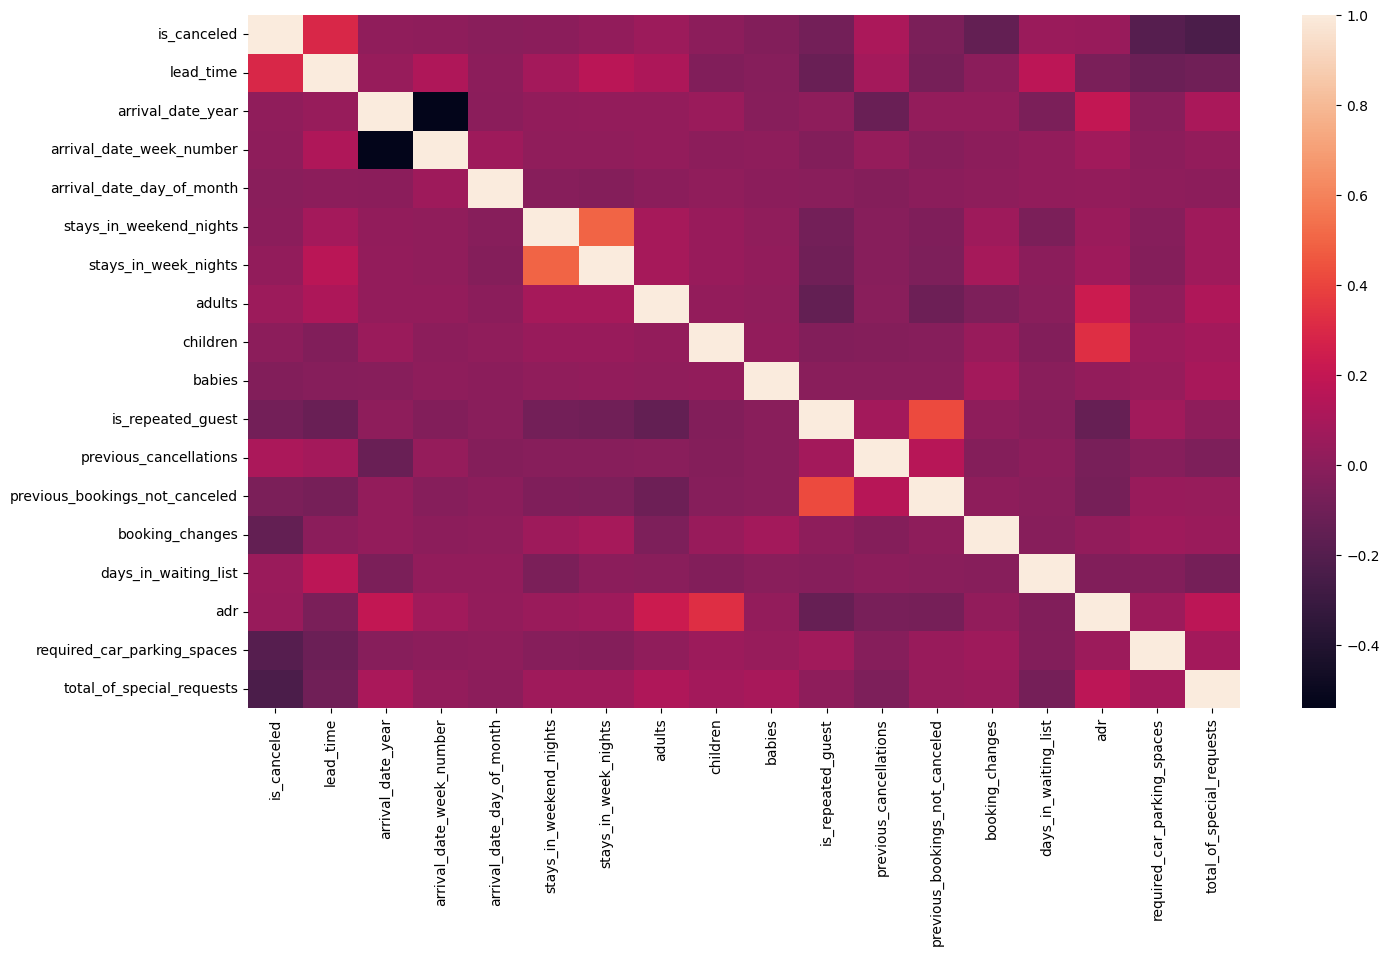

In [ ]:
plt.figure(figsize=(16, 9)) 
corr_matrix = hotel_df.corr()
sns.heatmap(corr_matrix)
plt.show()
     

In [ ]:
# Quais recursos numéricos estão correlacionados com o rótulo?
corr_with_cancel = corr_matrix["is_canceled"]
corr_with_cancel.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

# Imputação de valores ausentes - treinamento e teste

Antes de imputar valores ausentes, estou aqui fazendo a divisão  de treinamento e teste para evitar vazamento de dados.

In [ ]:
X_train, X_test = train_test_split(hotel_df, test_size = 0.30, random_state = 42)
X_train.shape, X_test.shape

((83573, 30), (35817, 30))

In [ ]:
# estou criando uma função de imputação
def imputar(df):
  df["country"]=df["country"].fillna("Missing")
  df["children"]=df["children"].fillna(df["children"].mode()[0])
  return(df)

In [ ]:
X_train = imputar(X_train)
X_test = imputar(X_test)
     

In [ ]:
hotel_df=pd.concat([X_train,X_test])
hotel_df.shape

(119390, 30)

# Feature Engineering

In [ ]:
def arrival_date(data):
    date=datetime.datetime.strptime(str(data["arrival_date_year"])+data["arrival_date_month"]+str(data["arrival_date_day_of_month"]),"%Y%B%d")
    return(date)

def family_or_not(data):
    if (data["adults"]>0) &((data["children"]>0)|(data["babies"]>0)):
        return(1)
    else:
        return(0)
        
def room_type_not_given(data):
    if data["reserved_room_type"]==data["assigned_room_type"]:
        return(0)
    else: 
        return(1)
     

In [ ]:
def feature_eng(data):
    data["arrival_date"]=data.apply(arrival_date,axis=1)
    data["arrival_date_weekday"]=data["arrival_date"].dt.weekday
    data["family_or_not"]=data.apply(family_or_not,axis=1)
    data["room_type_changes"]=data.apply(room_type_not_given,axis=1)

    data["Total_No_Of_Nights_Stayed"]=data["stays_in_weekend_nights"]+data["stays_in_week_nights"]
    data["Non_Refund_Flag"]=data["deposit_type"].apply(lambda x:1 if x=="Non Refund" else 0)
    return(data)

In [ ]:
hotel_df=feature_eng(hotel_df)


In [ ]:
# aqui estou fazendo a eliminação de variáveis usadas para criar novos recursos e reserve_status como rótulo depende disso
hotel_df = hotel_df.drop(['arrival_date_month','arrival_date_year','arrival_date_day_of_month',
                          'reservation_status','reservation_status_date'],axis= 1)

# Codificação das variáveis 

In [ ]:
hotel_df=pd.get_dummies(hotel_df,dtype='int64',drop_first=True)
     

hotel_df.shape

(119390, 240)

# Divisão dos dados 

In [ ]:
y=hotel_df["is_canceled"]
X=hotel_df.drop("is_canceled",axis=1)

# Split de treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42,stratify = y)

In [ ]:
# Y TREINO - conjunto de dados desbalanceado
y_train.value_counts()/y_train.shape[0]*100

0    62.958132
1    37.041868
Name: is_canceled, dtype: float64

In [ ]:
# Y TESTE
y_test.value_counts()/y_test.shape[0]*100

0    62.95893
1    37.04107
Name: is_canceled, dtype: float64

# Balanceamento dos dados

In [ ]:
merged_xy=X_train.merge(y_train,left_index=True,right_index=True)
not_cancel=merged_xy[merged_xy['is_canceled']==0]
cancel=merged_xy[merged_xy['is_canceled']==1]
print(not_cancel.shape)
print(cancel.shape)

(52616, 240)
(30957, 240)


In [ ]:
nao_amostra_cancel= resample(not_cancel,
                                replace = False, 
                                n_samples = len(cancel), 
                                random_state = 20) 
     

X_train = pd.concat([nao_amostra_cancel, cancel])
X_train.shape
     

(61914, 240)

In [ ]:
y_train=X_train['is_canceled']
X_train = X_train.drop('is_canceled',axis = 1)

# Eliminação de variáveis correlacionadas 

In [ ]:
corr = X_train.corr()
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
corr_threshold=0.90
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
to_drop

['Total_No_Of_Nights_Stayed',
 'assigned_room_type_G',
 'assigned_room_type_H',
 'assigned_room_type_P',
 'deposit_type_Non Refund']

In [ ]:
X_train = X_train.drop(X_train[to_drop],axis=1)
X_test = X_test.drop(X_test[to_drop], axis=1)

In [ ]:
X_train = X_train.drop('arrival_date',axis=1)
X_test = X_test.drop('arrival_date', axis=1)

# Seleção de features

In [ ]:
modelo = RandomForestClassifier(n_estimators=5,random_state=20)

In [ ]:
rfecv = RFECV(estimator=modelo, step=1, cv=2, scoring='f1')
selector = rfecv.fit(X_train,y_train)

In [ ]:
rank=selector.ranking_
feature_rank=pd.DataFrame({'Feature':X_train.columns,'Rank':rank})
feature_selected=(feature_rank[feature_rank['Rank']==1]['Feature']).to_list()
print(feature_selected)
print("O número de recursos selecionados",len(feature_selected))

['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'arrival_date_weekday', 'family_or_not', 'room_type_changes', 'Non_Refund_Flag', 'hotel_Resort Hotel', 'meal_HB', 'meal_SC', 'meal_Undefined', 'country_AGO', 'country_AUT', 'country_BEL', 'country_BRA', 'country_CHE', 'country_CHN', 'country_CN', 'country_DEU', 'country_ESP', 'country_FRA', 'country_GBR', 'country_IRL', 'country_ITA', 'country_NLD', 'country_POL', 'country_PRT', 'country_RUS', 'country_SWE', 'country_USA', 'market_segment_Corporate', 'market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'distribution_channel_Direct', 'distribution_channel_TA/TO', 'reserved_room_type_B', 'reserved_room_type_D', 'reserved_room_type_

# Descartando variáveis  não selecionadas

In [ ]:
X_train=X_train[feature_selected]
X_test=X_test[feature_selected]
     

X_test.shape, y_test.shape

((35817, 60), (35817,))

# Implementação dos modelos selecionados

Foi construida uma função que avalia o modelo usando o conjunto de treinamento e teste fornecido. Ela aceita diversos modelos, mas se o modelo for do tipo 'CatBoostClassifier', ele fará um gráfico da curva AUC-ROC durante o treinamento. Em seguida, a função calcula as previsões do modelo em termos de probabilidade e em termos binários usando um limiar definido pelo parâmetro 'threshold'. Depois disso, ela imprime as seguintes informações:

*  Matriz de Confusão para o conjunto de treinamento
* Matriz de Confusão para o conjunto de teste
* AUC ROC para o conjunto de treinamento
* AUC ROC para o conjunto de teste
* Relatório de Classificação para o conjunto de treinamento
* Relatório de Classificação para o conjunto de teste

In [ ]:
def avaliar_modelo(modeloUsado,Xtrain,ytrain,Xtest,ytest,threshold):
    if 'CatBoostClassifier' in str(modeloUsado):
      modeloUsado.fit(Xtrain,ytrain,eval_set=(Xtest,ytest),verbose=False,plot=True)
    else:
      modeloUsado.fit(Xtrain,ytrain)
    yTrainProbability=modeloUsado.predict_proba(Xtrain)[:,1]
    yTrainPrediction=np.where(yTrainProbability>threshold,1,0)
    
    yTestProbability=modeloUsado.predict_proba(Xtest)[:,1]
    yTestPrediction=np.where(yTestProbability>threshold,1,0)
    
    print(modeloUsado)

  

    #resultados
    #matriz de confusão
    print("\n")
    print(' Matriz de Confusão:Treino \n ')
    data = {'y_Real': ytrain,'y_Previsto': yTrainPrediction}
    df = pd.DataFrame(data, columns=['y_Real','y_Previsto'])
    confusion_matrix = pd.crosstab(df['y_Real'], df['y_Previsto'], rownames=['Real'], colnames=['Previsto'])
    sns.heatmap(confusion_matrix, annot=True,cmap='Blues',fmt="d")
    plt.show()
    print("\n")
    print('Matriz de Confusão: Teste: \n ')
    data = {'y_Real': ytest,'y_Previsto': yTestPrediction}
    df = pd.DataFrame(data, columns=['y_Real','y_Previsto'])
    confusion_matrix = pd.crosstab(df['y_Real'], df['y_Previsto'], rownames=['Real'], colnames=['Previsto'])
    sns.heatmap(confusion_matrix, annot=True,cmap='viridis',fmt="d")
    plt.show()
    
    #auc roc
    print("\n")
    print(' AUC_ROC: Treino: \n ', roc_auc_score(ytrain,yTrainProbability))
    print(' AUC_ROC: Teste: \n ', roc_auc_score(ytest,yTestProbability))
    # recall score
    print("\n")
    print('Report de classificação: Treino \n', classification_report(ytrain,yTrainPrediction))
    print('Report de classificação : Teste \n', classification_report(ytest,yTestPrediction))
     

# Regressão Logística

LogisticRegression(random_state=20)


 Matriz de Confusão:Treino 
 


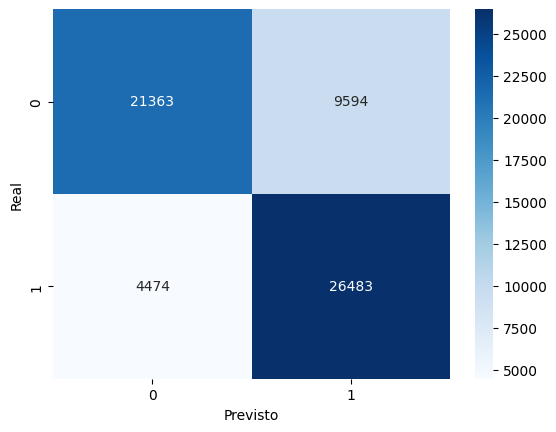



Matriz de Confusão: Teste: 
 


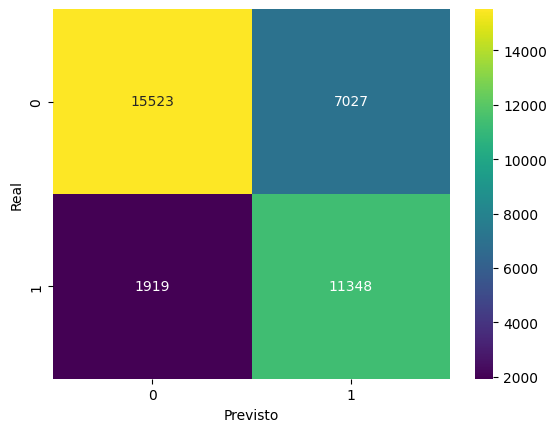



 AUC_ROC: Treino: 
  0.8731195424580218
 AUC_ROC: Teste: 
  0.8724436220975406


Report de classificação: Treino 
               precision    recall  f1-score   support

           0       0.83      0.69      0.75     30957
           1       0.73      0.86      0.79     30957

    accuracy                           0.77     61914
   macro avg       0.78      0.77      0.77     61914
weighted avg       0.78      0.77      0.77     61914

Report de classificação : Teste 
               precision    recall  f1-score   support

           0       0.89      0.69      0.78     22550
           1       0.62      0.86      0.72     13267

    accuracy                           0.75     35817
   macro avg       0.75      0.77      0.75     35817
weighted avg       0.79      0.75      0.75     35817



In [ ]:
lr=LogisticRegression(random_state=20)
result_lr=avaliar_modelo(lr,X_train,y_train,X_test,y_test,threshold = 0.4)

A interceptação é [-0.63317913]


Text(0.5, 0, 'pesos de coeficiente de recurso')

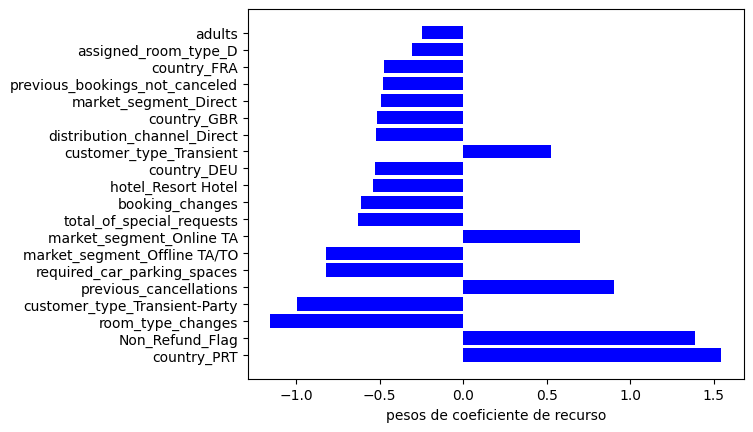

In [ ]:
print("A interceptação é",lr.intercept_)

weights_f = Series(lr.coef_[0],
                 index=X_train.columns.values)
weights_f2 = DataFrame(dict(weights = weights_f, weights_abs = weights_f.abs()))
weights_f2 = weights_f2.sort_values(by='weights_abs',ascending=False)
weights_f2 = weights_f2.reset_index().rename(columns={'index': 'Features'})

# plotando os pesos
fig = plt.figure()
ax = plt.subplot(111)
ax.barh(weights_f2['Features'][:20], weights_f2['weights'][:20], color='blue')
ax.set_xlabel('pesos de coeficiente de recurso')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Decision Trees

DecisionTreeClassifier(max_depth=10)


 Matriz de Confusão:Treino 
 


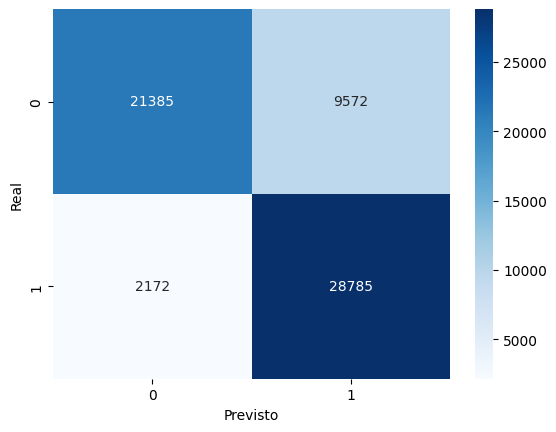



Matriz de Confusão: Teste: 
 


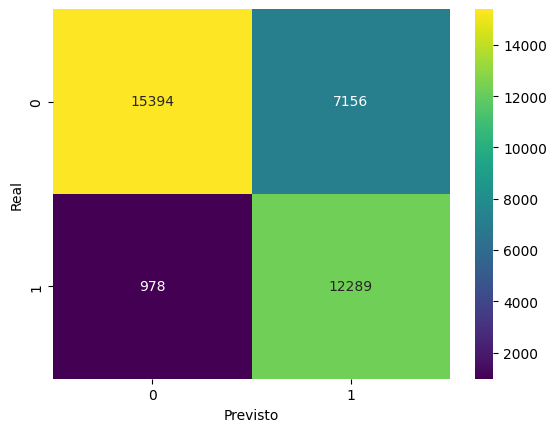



 AUC_ROC: Treino: 
  0.9214478086377001
 AUC_ROC: Teste: 
  0.913595816571033


Report de classificação: Treino 
               precision    recall  f1-score   support

           0       0.91      0.69      0.78     30957
           1       0.75      0.93      0.83     30957

    accuracy                           0.81     61914
   macro avg       0.83      0.81      0.81     61914
weighted avg       0.83      0.81      0.81     61914

Report de classificação : Teste 
               precision    recall  f1-score   support

           0       0.94      0.68      0.79     22550
           1       0.63      0.93      0.75     13267

    accuracy                           0.77     35817
   macro avg       0.79      0.80      0.77     35817
weighted avg       0.83      0.77      0.78     35817



In [ ]:
dtc=DecisionTreeClassifier(max_depth=10)
avaliar_modelo(dtc,X_train,y_train,X_test,y_test,threshold=0.4)

<Axes: >

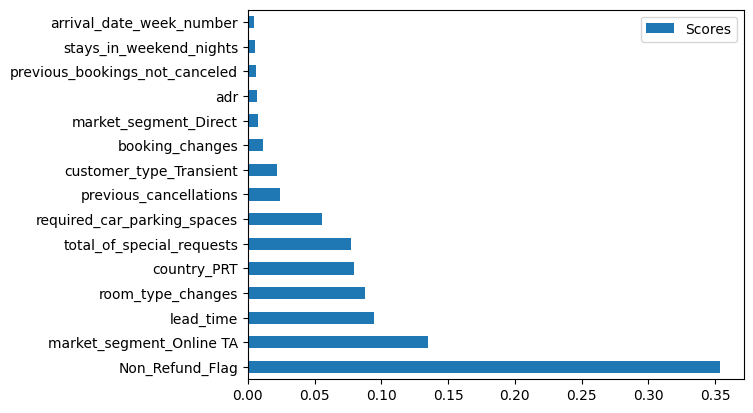

In [ ]:
#features de importância
pd.DataFrame(index=X_train.columns,data=dtc.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.barh()

# Random Forest

ajuste do modelo Random Forest

In [ ]:
rf_parameters = {"max_depth": [10,13],
                 "n_estimators": [10,100,500],
                 "min_samples_split": [2,5]}
                 
rf_model = RandomForestClassifier()
rf_cv_model = GridSearchCV(rf_model,
                           rf_parameters,
                           cv = 3)
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 13], 'min_samples_split': [2, 5],
                         'n_estimators': [10, 100, 500]})

In [ ]:
print('Melhores parametros: ' + str(rf_cv_model.best_params_))

Melhores parametros: {'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 500}


RandomForestClassifier(max_depth=13, n_estimators=500)


 Matriz de Confusão:Treino 
 


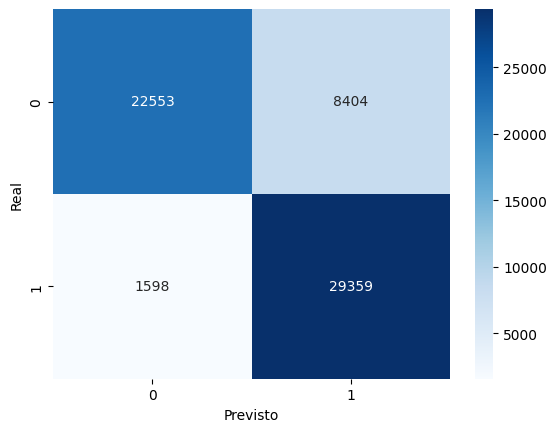



Matriz de Confusão: Teste: 
 


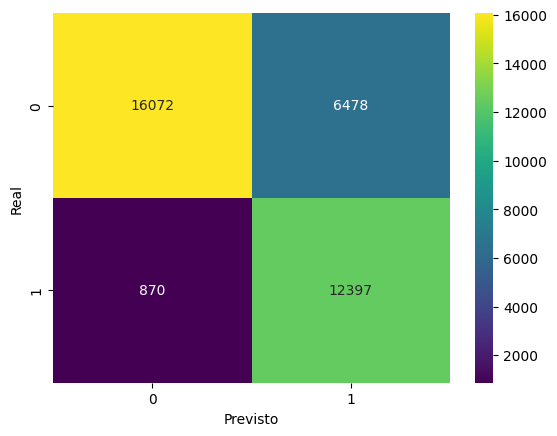



 AUC_ROC: Treino: 
  0.9444186992946352
 AUC_ROC: Teste: 
  0.9318125428998181


Report de classificação: Treino 
               precision    recall  f1-score   support

           0       0.93      0.73      0.82     30957
           1       0.78      0.95      0.85     30957

    accuracy                           0.84     61914
   macro avg       0.86      0.84      0.84     61914
weighted avg       0.86      0.84      0.84     61914

Report de classificação : Teste 
               precision    recall  f1-score   support

           0       0.95      0.71      0.81     22550
           1       0.66      0.93      0.77     13267

    accuracy                           0.79     35817
   macro avg       0.80      0.82      0.79     35817
weighted avg       0.84      0.79      0.80     35817



In [ ]:
rf_tuned = RandomForestClassifier(max_depth = 13,
                                  min_samples_split = 2,
                                  n_estimators = 500)

result_rf_tuned=avaliar_modelo(rf_tuned,X_train,y_train,X_test,y_test,threshold=0.4)

<Axes: >

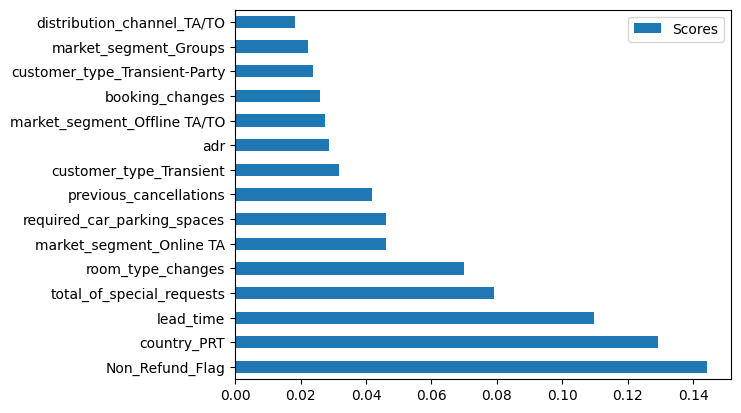

In [ ]:
pd.DataFrame(index=X_train.columns,data=rf_tuned.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.barh()

RandomForestClassifier(random_state=20)


 Matriz de Confusão:Treino 
 


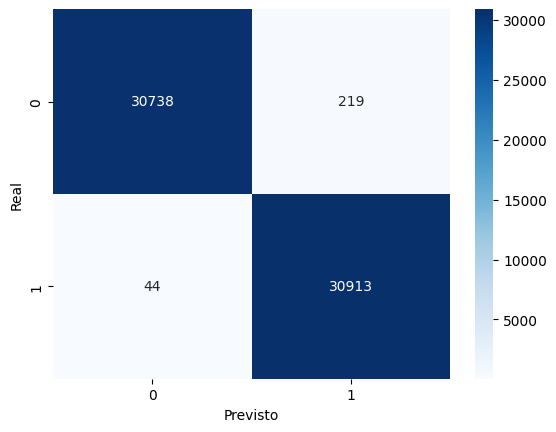



Matriz de Confusão: Teste: 
 


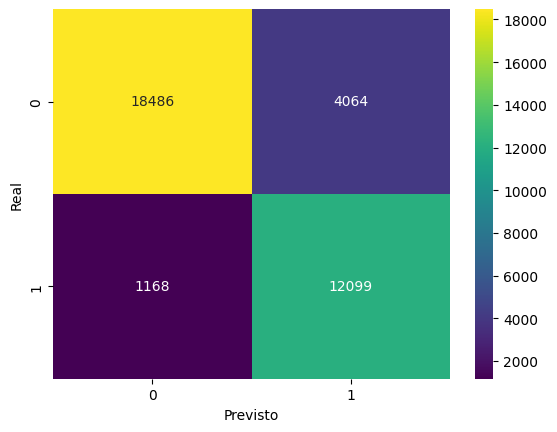



 AUC_ROC: Treino: 
  0.9997304734031713
 AUC_ROC: Teste: 
  0.9498918895340237


Report de classificação: Treino 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     30957
           1       0.99      1.00      1.00     30957

    accuracy                           1.00     61914
   macro avg       1.00      1.00      1.00     61914
weighted avg       1.00      1.00      1.00     61914

Report de classificação : Teste 
               precision    recall  f1-score   support

           0       0.94      0.82      0.88     22550
           1       0.75      0.91      0.82     13267

    accuracy                           0.85     35817
   macro avg       0.84      0.87      0.85     35817
weighted avg       0.87      0.85      0.86     35817



In [ ]:
rf = RandomForestClassifier(random_state=20)
avaliar_modelo(rf,X_train,y_train,X_test,y_test,threshold=0.4)

# CatBoost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))



 Matriz de Confusão:Treino 
 


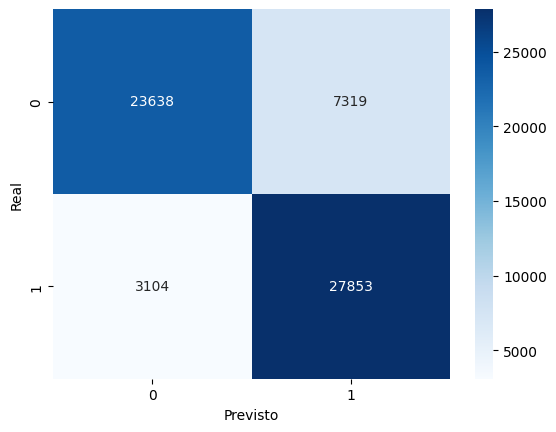



Matriz de Confusão: Teste: 
 


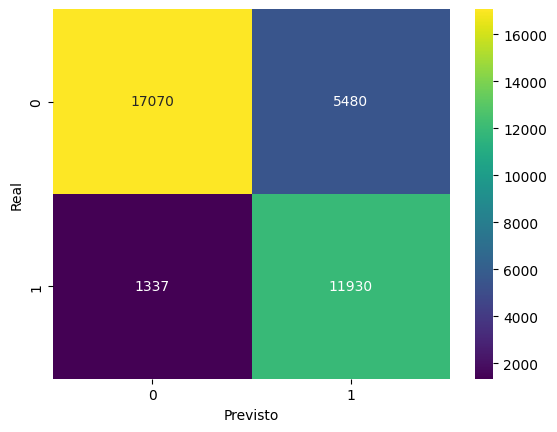



 AUC_ROC: Treino: 
  0.9279288262334429
 AUC_ROC: Teste: 
  0.9255063452873166


Report de classificação: Treino 
               precision    recall  f1-score   support

           0       0.88      0.76      0.82     30957
           1       0.79      0.90      0.84     30957

    accuracy                           0.83     61914
   macro avg       0.84      0.83      0.83     61914
weighted avg       0.84      0.83      0.83     61914

Report de classificação : Teste 
               precision    recall  f1-score   support

           0       0.93      0.76      0.83     22550
           1       0.69      0.90      0.78     13267

    accuracy                           0.81     35817
   macro avg       0.81      0.83      0.81     35817
weighted avg       0.84      0.81      0.81     35817



In [ ]:
catboost = CatBoostClassifier(iterations =500,use_best_model=True,max_depth=2,od_type='Iter',custom_loss='F1')
result_catboost=avaliar_modelo(catboost,X_train,y_train,X_test,y_test,threshold=0.4)

<Axes: >

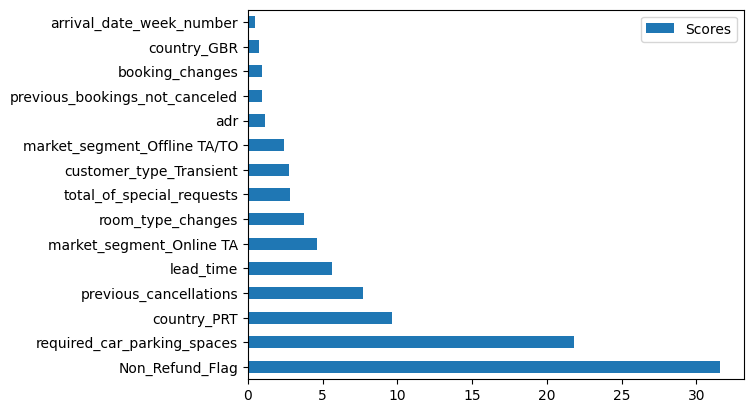

In [ ]:
#Feature importances
pd.DataFrame(index=X_train.columns,data=catboost.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.barh()